# Step 1 : importing Essential Libraries

In [57]:
%matplotlib inline
import os  # Operating system operations
import itertools  # for efficient looping

import numpy as np  # for numerical operations
np.random.seed(123)  # fix seed for reproducibility
import pandas as pd  # for data manipulation
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # for advanced plotting

from glob import glob  # for file location
from PIL import Image  # for image manipulation

# sklearn utilities
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

# keras for deep learning
import keras
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical


In [87]:
def plot_model_performance(history):
    # Determine the correct key for accuracy
    accuracy_key = "acc" if "acc" in history.history else "accuracy"
    val_accuracy_key = "val_acc" if "val_acc" in history.history else "val_accuracy"
    
    # Plot training and validation accuracy
    epochs = range(1, len(history.history[accuracy_key]) + 1)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history[accuracy_key], label='Training Accuracy')
    plt.plot(epochs, history.history[val_accuracy_key], label='Validation Accuracy')
    plt.title('Model Accuracy Across Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    
    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Across Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


# Step 2 : Making Dictionary of images and labels

In [59]:
# Set the base directory for skin images
base_dir = os.path.join('..', 'input')

# Create a dictionary to map image IDs to their file paths
# Glob pattern matches all jpg files in the base directory and its subdirectories
image_paths = {os.path.splitext(os.path.basename(file))[0]: file
               for file in glob(os.path.join(base_dir, '*', '*.jpg'))}

# Dictionary for mapping lesion abbreviations to full names
lesion_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


# Step 3 : Reading & Processing data

In [60]:


skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

# Calculate the number of samples for each class in the 10% sample
# sample_size = int(len(skin_df) * 0.1)
# class_counts = skin_df['cell_type_idx'].value_counts()
# class_proportions = class_counts / class_counts.sum()
# class_sample_counts = (class_proportions * sample_size).astype(int)

# Sample from each class with the desired proportions
# skin_df = pd.concat([skin_df[skin_df['cell_type_idx'] == cls].sample(class_sample_counts[cls], replace=True) for cls in class_sample_counts.index])

# Shuffle the sampled data
# skin_df = skin_df.sample(frac=1, random_state=123)


In [61]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


# Step 4 : Data Cleaning

In [62]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [63]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [64]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [65]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


# Step 5 : EDA

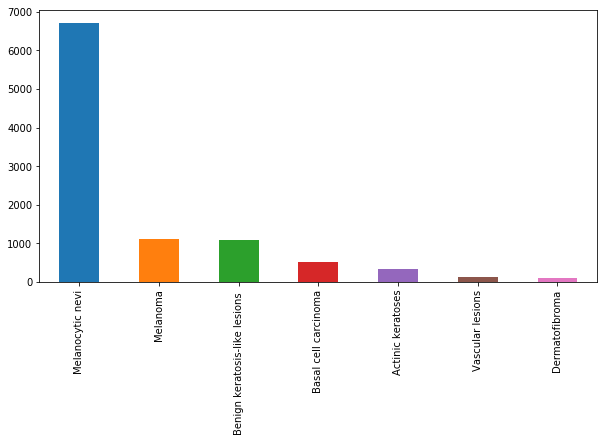

In [66]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

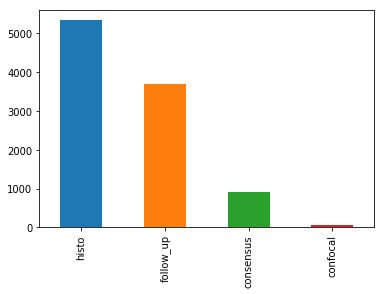

In [67]:
skin_df['dx_type'].value_counts().plot(kind='bar')

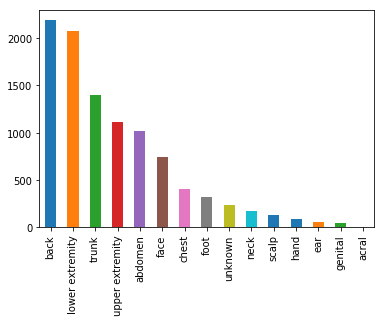

In [68]:
skin_df['localization'].value_counts().plot(kind='bar')

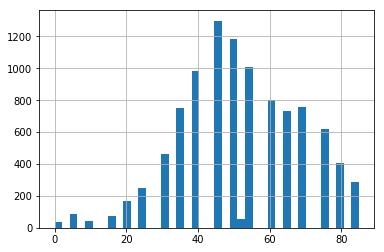

In [69]:
skin_df['age'].hist(bins=40)

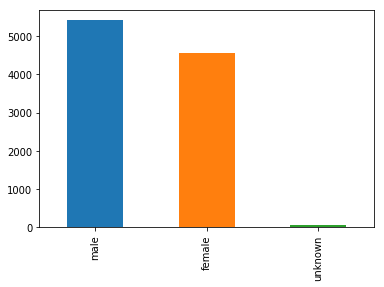

In [70]:

skin_df['sex'].value_counts().plot(kind='bar')

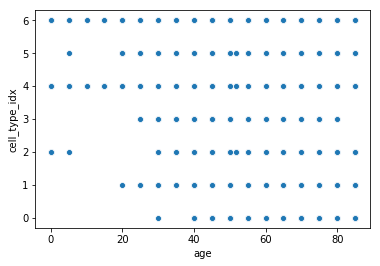

In [71]:
sns.scatterplot('age','cell_type_idx',data=skin_df)

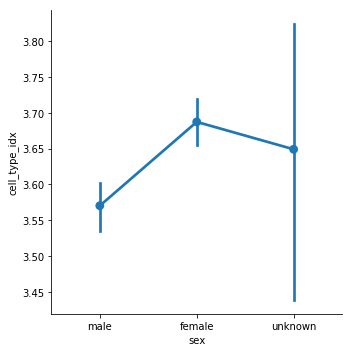

In [72]:
sns.factorplot('sex','cell_type_idx',data=skin_df)

# Step 6: Loading and resizing of images

In [73]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [74]:
# Step 6: Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [75]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


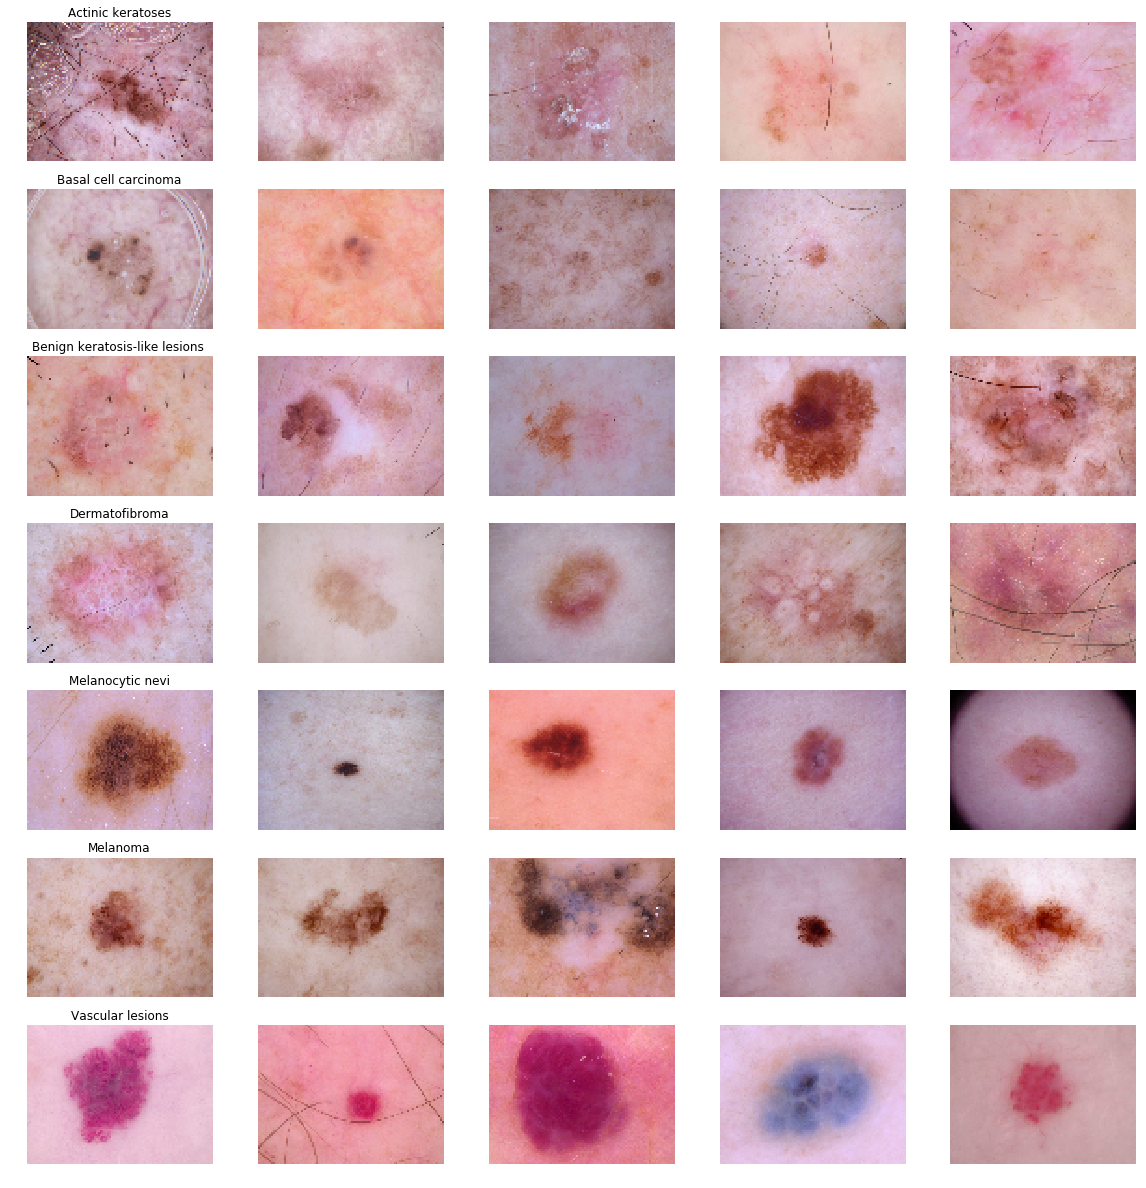

In [76]:
# Set the number of samples per category
num_samples = 5

# Create a figure to display sample images for each skin condition
# Setting up the figure size based on the number of samples
fig, axis_matrix = plt.subplots(7, num_samples, figsize=(4 * num_samples, 3 * 7))

# Loop through each category of skin conditions
for axes_row, (condition_name, condition_rows) in zip(axis_matrix, skin_df.sort_values(['cell_type']).groupby('cell_type')):
    # Set the title of the first column to the skin condition name
    axes_row[0].set_title(condition_name)
    
    # Sample 'n_samples' images from each category to display
    for ax, (_, row) in zip(axes_row, condition_rows.sample(num_samples, random_state=1234, replace=True).iterrows()):
        # Display the image in the subplot
        ax.imshow(row['image'])
        # Turn off the axis to only show the image
        ax.axis('off')

# Save the figure to a file with high resolution
fig.savefig('category_samples.png', dpi=300)


In [77]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [78]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

# Step 7 : Train Test Split

In [79]:
# Splitting the dataset into training and testing sets
# Features and target variables are divided such that 20% of the data is reserved for testing
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(
    features,  # The input features to the model
    target,    # The target variable that we're trying to predict
    test_size=0.20,  # Percentage of data to allocate to the test set
    random_state=1234  # Seed for random splitting process for reproducibility
)


# Step 8 : Normalization

In [80]:
# Convert image lists to numpy arrays for processing
x_train = np.array(x_train_o['image'].tolist())
x_test = np.array(x_test_o['image'].tolist())

# Calculate the mean and standard deviation of the training data
x_train_mean = x_train.mean()
x_train_std = x_train.std()

# Normalize the training data by subtracting the mean and dividing by the standard deviation
x_train = (x_train - x_train_mean) / x_train_std

# Calculate the mean and standard deviation of the testing data
# Then normalize the testing data in the same way
x_test_mean = x_test.mean()
x_test_std = x_test.std()
x_test = (x_test - x_test_mean) / x_test_std


# Step 9 : Label Encoding

In [81]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [82]:
# Apply one-hot encoding to the training and testing labels
# This converts the categorical labels into a format that's suitable for classification models
y_train = to_categorical(y_train_o, num_classes=7)
y_test = to_categorical(y_test_o, num_classes=7)


# Step 10 : Splitting training and validation split

In [83]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

# Step 11 : Model Building

In [84]:
# Reshape the images to the required dimensions for the model input
# The desired shape is (height, width, channels) which is (75, 100, 3) in this case
x_train = x_train.reshape((-1, 75, 100, 3))
x_test = x_test.reshape((-1, 75, 100, 3))
x_validate = x_validate.reshape((-1, 75, 100, 3))


In [85]:
batch_size=32
epochs=20

from keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(75, 100, 3))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Freeze the ResNet50 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Step 12: Fitting the Model (with Data Augmentation)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) / batch_size,
    epochs=epochs,
    validation_data=(x_validate, y_validate),
    callbacks=[reduce_lr]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 3, 4, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 24576)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               12583424  
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
__________

# Step 13 : Model Evaluation

Test loss: 0.6231
Test accuracy: 77.2841%


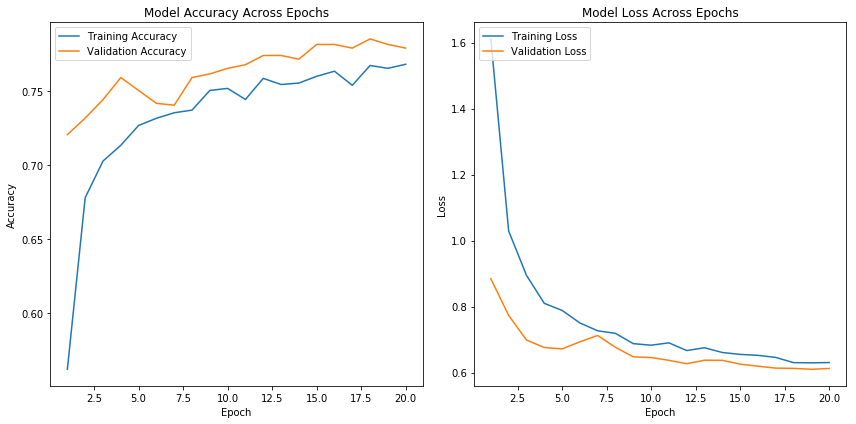

Confusion matrix, without normalization


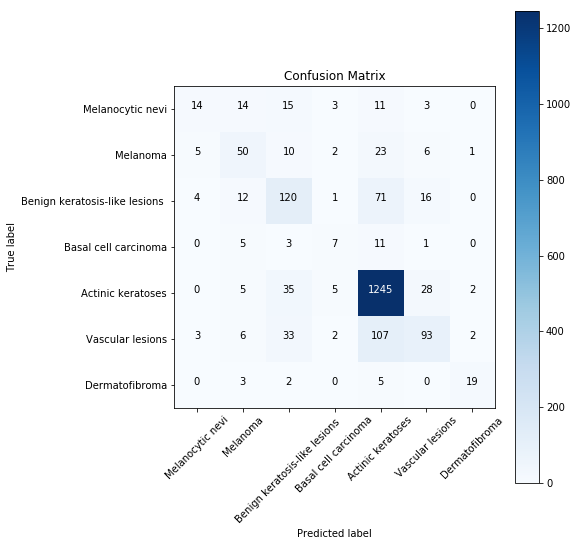

Number of misclassified images: 455 out of 2003


In [89]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.4%}')

# Function to plot confusion matrix in a more intuitive and readable manner
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.2f}" if normalize else f"{cm[i, j]:d}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting the model's performance over epochs
plot_model_performance(history)

# Predicting labels for the test set
predicted_probs = model.predict(x_test)
predicted_classes = np.argmax(predicted_probs, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Generating and plotting the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plot_confusion_matrix(conf_matrix, classes=list(lesion_type_dict.values()), title='Confusion Matrix')

# Analyze misclassifications
misclassified_indices = np.where(predicted_classes != true_classes)[0]
print(f"Number of misclassified images: {len(misclassified_indices)} out of {len(y_test)}")
